# Define segment and predict sales associated

## Importations of packages 

In [70]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import os
import s3fs
import re
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from sklearn.utils import class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
from sklearn.naive_bayes import GaussianNB
from scipy.optimize import fsolve
import io

import pickle
import warnings

## load databases

In [71]:
# Create filesystem object
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

In [270]:
type_of_activity = "musee"

In [73]:
def load_train_test(type_of_activity):
    BUCKET = f"projet-bdc2324-team1/Generalization/{type_of_activity}"
    File_path_train = BUCKET + "/Train_set.csv"
    File_path_test = BUCKET + "/Test_set.csv"
    
    with fs.open( File_path_train, mode="rb") as file_in:
        dataset_train = pd.read_csv(file_in, sep=",")
        # dataset_train['y_has_purchased'] = dataset_train['y_has_purchased'].fillna(0)

    with fs.open(File_path_test, mode="rb") as file_in:
        dataset_test = pd.read_csv(file_in, sep=",")
        # dataset_test['y_has_purchased'] = dataset_test['y_has_purchased'].fillna(0)
    
    return dataset_train, dataset_test

In [271]:
dataset_train, dataset_test = load_train_test(type_of_activity)
dataset_train.isna().sum()

/tmp/ipykernel_1080/2350085345.py:7: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_train = pd.read_csv(file_in, sep=",")


customer_id                    0
nb_tickets                     0
nb_purchases                   0
total_amount                   0
nb_suppliers                   0
vente_internet_max             0
purchase_date_min              0
purchase_date_max              0
time_between_purchase          0
nb_tickets_internet            0
street_id                      0
structure_id              389658
mcp_contact_id            150354
fidelity                       0
tenant_id                      0
is_partner                     0
deleted_at                434278
gender                         0
is_email_true                  0
opt_in                         0
last_buying_date          183987
max_price                 183987
ticket_sum                     0
average_price              94783
average_purchase_delay    183987
average_price_basket      183987
average_ticket_basket     183987
total_price                89204
purchase_count                 0
first_buying_date         183987
country   

In [77]:
def features_target_split(dataset_train, dataset_test):
    
    features_l = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 'purchase_date_min', 'purchase_date_max', 
            'time_between_purchase', 'nb_tickets_internet', 'fidelity',  'is_email_true', 'opt_in', #'is_partner',
            'gender_female', 'gender_male', 'gender_other', 'nb_campaigns', 'nb_campaigns_opened']

    # we suppress fidelity, time between purchase, and gender other (colinearity issue)
    """
    features_l = ['nb_tickets', 'nb_purchases', 'total_amount', 'nb_suppliers', 'vente_internet_max', 
                  'purchase_date_min', 'purchase_date_max', 'nb_tickets_internet',  'is_email_true', 
                  'opt_in', 'gender_female', 'gender_male', 'nb_campaigns', 'nb_campaigns_opened']
    """
    
    X_train = dataset_train[features_l]
    y_train = dataset_train[['y_has_purchased']]

    X_test = dataset_test[features_l]
    y_test = dataset_test[['y_has_purchased']]
    return X_train, X_test, y_train, y_test

In [272]:
X_train, X_test, y_train, y_test = features_target_split(dataset_train, dataset_test)
print("Shape train : ", X_train.shape)
print("Shape test : ", X_test.shape)

Shape train :  (434278, 17)
Shape test :  (186120, 17)


## get results from the logit cross validated model

In [79]:
X_test

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0             4.0           1.0        100.00           1.0   
1             1.0           1.0         55.00           1.0   
2            17.0           1.0         80.00           1.0   
3             4.0           1.0        120.00           1.0   
4            34.0           2.0        416.00           1.0   
...           ...           ...           ...           ...   
96091         1.0           1.0         67.31           1.0   
96092         1.0           1.0         61.41           1.0   
96093         0.0           0.0          0.00           0.0   
96094         1.0           1.0         79.43           1.0   
96095         0.0           0.0          0.00           0.0   

       vente_internet_max  purchase_date_min  purchase_date_max  \
0                     0.0           5.177187           5.177187   
1                     0.0         426.265613         426.265613   
2                     0.0         436.033437         436.033437   
3                     0.0           5.196412           5.196412   
4                     0.0         478.693148         115.631470   
...                   ...                ...                ...   
96091                 1.0         278.442257         278.442257   
96092                 1.0         189.207373         189.207373   
96093                 0.0         550.000000         550.000000   
96094                 1.0         279.312905         279.312905   
96095                 0.0         550.000000         550.000000   

       time_between_purchase  nb_tickets_internet  fidelity  is_email_true  \
0                   0.000000                  0.0         1           True   
1                   0.000000                  0.0         2           True   
2                   0.000000                  0.0         2           True   
3                   0.000000                  0.0         1           True   
4                 363.061678                  0.0         4           True   
...                      ...                  ...       ...            ...   
96091               0.000000                  1.0         2           True   
96092               0.000000                  1.0         1           True   
96093              -1.000000                  0.0         1           True   
96094               0.000000                  1.0         1           True   
96095              -1.000000                  0.0         2           True   

       opt_in  gender_female  gender_male  gender_other  nb_campaigns  \
0       False              1            0             0           0.0   
1        True              0            1             0           0.0   
2        True              1            0             0           0.0   
3       False              1            0             0           0.0   
4       False              1            0             0           0.0   
...       ...            ...          ...           ...           ...   
96091   False              0            1             0          15.0   
96092   False              0            1             0          12.0   
96093    True              1            0             0          29.0   
96094   False              0            1             0          20.0   
96095   False              0            1             0          31.0   

       nb_campaigns_opened  
0                      0.0  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  
...                    ...  
96091                  5.0  
96092                  9.0  
96093                  3.0  
96094                  4.0  
96095                  4.0  

[96096 rows x 17 columns]

In [80]:
def load_model(type_of_activity, model):
    BUCKET = f"projet-bdc2324-team1/Output_model/{type_of_activity}/{model}/"
    filename = model + '.pkl'
    file_path = BUCKET + filename
    with fs.open(file_path, mode="rb") as f:
        model_bytes = f.read()

    model = pickle.loads(model_bytes)
    return model

In [286]:
model = load_model(type_of_activity, "LogisticRegression_cv")
# model = load_model(type_of_activity, "randomF_cv")
model

GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['nb_tickets',
                                                                          'nb_purchases',
                                                                          'total_amount',
                                                                          'nb_suppliers',
                                                                          'vente_internet_max',
                                                                          'purchase_date_min',
                                                                          'purchase_date_max',
                                                                          'time_between_purchase',
                                                                          'nb_tickets_internet',
                                                                          'nb_campaigns',
                                                                          'nb_...
       1.562500e-02, 3.125000e-02, 6.250000e-02, 1.250000e-01,
       2.500000e-01, 5.000000e-01, 1.000000e+00, 2.000000e+00,
       4.000000e+00, 8.000000e+00, 1.600000e+01, 3.200000e+01,
       6.400000e+01]),
                         'LogisticRegression_cv__class_weight': ['balanced',
                                                                 {0.0: 0.5223906809346011,
                                                                  1.0: 11.665359406898034}],
                         'LogisticRegression_cv__penalty': ['l1', 'l2']},
             scoring=make_scorer(recall_score, response_method='predict'))

## Quartile clustering

In [287]:
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

In [288]:
X_test_segment = X_test

X_test_segment["has_purchased"] = y_test
X_test_segment["has_purchased_estim"] = y_pred
X_test_segment["score"] = y_pred_prob
X_test_segment["quartile"] = np.where(X_test['score']<0.25, '1',
                   np.where(X_test['score']<0.5, '2',
                   np.where(X_test['score']<0.75, '3', '4')))
X_test_segment.head(10)

/tmp/ipykernel_1080/375041546.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_segment["has_purchased"] = y_test
/tmp/ipykernel_1080/375041546.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_segment["has_purchased_estim"] = y_pred
/tmp/ipykernel_1080/375041546.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

nb_tickets  nb_purchases  total_amount  nb_suppliers  vente_internet_max  \
0         2.0           1.0          22.0           1.0                 1.0   
1       269.0           8.0          50.0           2.0                 1.0   
2         0.0           0.0           0.0           0.0                 0.0   
3         0.0           0.0           0.0           0.0                 0.0   
4         0.0           0.0           0.0           0.0                 0.0   
5         0.0           0.0           0.0           0.0                 0.0   
6         0.0           0.0           0.0           0.0                 0.0   
7         0.0           0.0           0.0           0.0                 0.0   
8         1.0           1.0          11.0           1.0                 1.0   
9         0.0           0.0           0.0           0.0                 0.0   

   purchase_date_min  purchase_date_max  time_between_purchase  \
0         307.203553         307.203553               0.000000   
1         378.208090          39.389595             338.818495   
2         550.000000         550.000000              -1.000000   
3         550.000000         550.000000              -1.000000   
4         550.000000         550.000000              -1.000000   
5         550.000000         550.000000              -1.000000   
6         550.000000         550.000000              -1.000000   
7         550.000000         550.000000              -1.000000   
8         456.255104         456.255104               0.000000   
9         550.000000         550.000000              -1.000000   

   nb_tickets_internet  fidelity  ...  gender_female  gender_male  \
0                  2.0         1  ...              0            0   
1                 66.0        10  ...              0            0   
2                  0.0         0  ...              0            1   
3                  0.0         0  ...              1            0   
4                  0.0         0  ...              0            0   
5                  0.0         0  ...              1            0   
6                  0.0         1  ...              0            1   
7                  0.0         0  ...              0            1   
8                  1.0         1  ...              0            0   
9                  0.0         0  ...              0            1   

   gender_other  nb_campaigns  nb_campaigns_opened  has_purchased  \
0             1           0.0                  0.0            0.0   
1             1          65.0                  1.0            1.0   
2             0           4.0                  2.0            0.0   
3             0           2.0                  0.0            0.0   
4             1           4.0                  0.0            0.0   
5             0           7.0                  0.0            0.0   
6             0           2.0                  0.0            0.0   
7             0          10.0                  8.0            0.0   
8             1           3.0                  3.0            0.0   
9             0          10.0                  6.0            0.0   

   has_purchased_estim     score  quartile  score_adjusted  
0                  0.0  0.367961         2        0.010594  
1                  1.0  0.998731         4        0.397108  
2                  0.0  0.211997         1        0.014916  
3                  0.0  0.246563         1        0.024670  
4                  0.0  0.108575         1        0.025205  
5                  0.0  0.257244         2        0.046644  
6                  0.0  0.203196         1        0.023026  
7                  0.0  0.240049         1        0.003825  
8                  0.0  0.340098         2        0.006850  
9                  0.0  0.234470         1        0.003745  

[10 rows x 22 columns]

In [86]:
def df_segment(df, y, model) :

    y_pred = model.predict(df)
    y_pred_prob = model.predict_proba(df)[:, 1]

    df_segment = df

    df_segment["has_purchased"] = y
    df_segment["has_purchased_estim"] = y_pred
    df_segment["score"] = y_pred_prob
    df_segment["quartile"] = np.where(df_segment['score']<0.25, '1',
                       np.where(df_segment['score']<0.5, '2',
                       np.where(df_segment['score']<0.75, '3', '4')))

    return df_segment

In [88]:
df_segment(X_test, y_test, model)

/tmp/ipykernel_1080/2624515794.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segment["has_purchased"] = y
/tmp/ipykernel_1080/2624515794.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_segment["has_purchased_estim"] = y_pred
/tmp/ipykernel_1080/2624515794.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0             4.0           1.0        100.00           1.0   
1             1.0           1.0         55.00           1.0   
2            17.0           1.0         80.00           1.0   
3             4.0           1.0        120.00           1.0   
4            34.0           2.0        416.00           1.0   
...           ...           ...           ...           ...   
96091         1.0           1.0         67.31           1.0   
96092         1.0           1.0         61.41           1.0   
96093         0.0           0.0          0.00           0.0   
96094         1.0           1.0         79.43           1.0   
96095         0.0           0.0          0.00           0.0   

       vente_internet_max  purchase_date_min  purchase_date_max  \
0                     0.0           5.177187           5.177187   
1                     0.0         426.265613         426.265613   
2                     0.0         436.033437         436.033437   
3                     0.0           5.196412           5.196412   
4                     0.0         478.693148         115.631470   
...                   ...                ...                ...   
96091                 1.0         278.442257         278.442257   
96092                 1.0         189.207373         189.207373   
96093                 0.0         550.000000         550.000000   
96094                 1.0         279.312905         279.312905   
96095                 0.0         550.000000         550.000000   

       time_between_purchase  nb_tickets_internet  fidelity  ...  opt_in  \
0                   0.000000                  0.0         1  ...   False   
1                   0.000000                  0.0         2  ...    True   
2                   0.000000                  0.0         2  ...    True   
3                   0.000000                  0.0         1  ...   False   
4                 363.061678                  0.0         4  ...   False   
...                      ...                  ...       ...  ...     ...   
96091               0.000000                  1.0         2  ...   False   
96092               0.000000                  1.0         1  ...   False   
96093              -1.000000                  0.0         1  ...    True   
96094               0.000000                  1.0         1  ...   False   
96095              -1.000000                  0.0         2  ...   False   

       gender_female  gender_male  gender_other  nb_campaigns  \
0                  1            0             0           0.0   
1                  0            1             0           0.0   
2                  1            0             0           0.0   
3                  1            0             0           0.0   
4                  1            0             0           0.0   
...              ...          ...           ...           ...   
96091              0            1             0          15.0   
96092              0            1             0          12.0   
96093              1            0             0          29.0   
96094              0            1             0          20.0   
96095              0            1             0          31.0   

       nb_campaigns_opened  has_purchased  has_purchased_estim     score  \
0                      0.0            0.0                  0.0  0.006066   
1                      0.0            1.0                  0.0  0.288847   
2                      0.0            0.0                  0.0  0.103264   
3                      0.0            0.0                  0.0  0.008928   
4                      0.0            1.0                  1.0  0.992809   
...                    ...            ...                  ...       ...   
96091                  5.0            1.0                  0.0  0.351762   
96092                  9.0            0.0                  1.0  0.567814   
96093                  3.0            0.0                  0.0  0.0

## definition of functions to compute the bias of scores and adjust it 

Le biais est calculé de la façon suivante. 
En notant $\hat{p(x_i)}$ le score calculé (estimé par la modélisation) et $p(x_i)$ le vrai score (sans biais), et $\beta$ le logarithme du biais, on a : \
$\ln{\frac{\hat{p(x_i)}}{1-\hat{p(x_i)}}} = \beta + \ln{\frac{p(x_i)}{1-p(x_i)}}$ \
$ \frac{\hat{p(x_i)}}{1-\hat{p(x_i)}} = \exp(\beta) . \frac{p(x_i)}{1-p(x_i)} $ , soit : \
$p(x_i) = {\frac{\frac{\hat{p(x_i)}}{1-\hat{p(x_i)}}}{B+\frac{\hat{p(x_i)}}{1-\hat{p(x_i)}}}}$ \
Ce qu'on appelle biais et qu'on estime dans le code par la suite est : $B=\exp(\beta) $. Les probabilités ne sont donc pas biaisées si $B=1$. Il y a surestimation si $B>1$. 

On cherche le B qui permette d'ajuster les probabilités de telle sorte que la somme des scores soit égale à la somme des y_has_purchased. Cela revient à résoudre : 

\begin{equation}
\sum_{i}{\frac{\frac{\hat{p(x_i)}}{1-\hat{p(x_i)}}}{B+\frac{\hat{p(x_i)}}{1-\hat{p(x_i)}}}} = \sum_{i}{Y_i}
\end{equation}

C'est ce que fait la fonction find_bias. 

Note sur les notations : \
$\hat{p(x_i)}$ correspond à ce qu'on appelle le score et $p(x_i)$ à ce qu'on appellera le score adjusted

In [89]:
# compute adjusted score from odd ratios (cf formula above)
def adjusted_score(odd_ratio, bias) :
    adjusted_score = odd_ratio/(bias+odd_ratio)
    return adjusted_score

In [90]:
# when the score is 1 we cannot compute the odd ratio, so we adjust scores equal to 1
# we set the second best score instead

def adjust_score_1(score) :
    second_best_score = np.array([element for element in score if element !=1]).max()
    new_score = np.array([element if element!=1 else second_best_score for element in score])    
    return new_score

In [91]:
def odd_ratio(score) :
    return score / (1 - score)

In [92]:
# definition of a function that automatically detects the bias

def find_bias(odd_ratios, y_objective, initial_guess=6) :
    """
    results = minimize(lambda bias : (sum([adjusted_score(element, bias) for element in list(odd_ratios)]) - y_objective)**2 ,
    initial_guess , method = "BFGS")

    estimated_bias = results.x[0]
    """

    # faster method
    bias_estimated = fsolve(lambda bias : sum([adjusted_score(element, bias) for element in list(odd_ratios)]) - y_objective, x0=6)
 
    return bias_estimated[0]

In [289]:
print(X_test_segment["score"].mean(), y_test["y_has_purchased"].mean())
y_train["y_has_purchased"].mean()

0.3940650533525649 0.04284869976359338


0.04286194557403322

In [290]:
# computation with the function defined

bias_test_set = find_bias(odd_ratios = odd_ratio(adjust_score_1(X_test_segment["score"])), 
                           y_objective = y_test["y_has_purchased"].sum(),
                           initial_guess=6)
bias_test_set

22.577005337484817

In [291]:
# comparison with bias of the train set
X_train_score = model.predict_proba(X_train)[:, 1]

bias_train_set = find_bias(odd_ratios = odd_ratio(adjust_score_1(X_train_score)), 
                           y_objective = y_train["y_has_purchased"].sum(),
                           initial_guess=6)
bias_train_set

22.690061493186622

In [292]:
print("betâ test - betâ train = ",np.log(bias_test_set/bias_train_set))

betâ test - betâ train =  -0.0049950835646278635


In [293]:
# impact of considering a bias computed on train set instead of test set - totally neglectable

score_adjusted_test = adjusted_score(odd_ratio(adjust_score_1(X_test_segment["score"])), bias = bias_test_set)
score_adjusted_train = adjusted_score(odd_ratio(adjust_score_1(X_test_segment["score"])), bias = bias_train_set)

print("mean absolute erreur",abs(score_adjusted_test-score_adjusted_train).mean())

mean absolute erreur 0.00017894295558797563


In [294]:
# adjust scores accordingly 

# X_test_segment["score_adjusted"] = adjusted_score(odd_ratio(adjust_score_1(X_test_segment["score"])), bias = bias_test_set)

# actually, we are not supposed to have X_test, so the biais is estimated on X_train
# X_test_segment["score_adjusted"] = adjusted_score(odd_ratio(adjust_score_1(X_test_segment["score"])), bias = bias_train_set)
X_test_segment["score_adjusted"] = score_adjusted_train

/tmp/ipykernel_1080/1825363704.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_segment["score_adjusted"] = score_adjusted_train


In [295]:
# check 

MSE_score = ((X_test_segment["score"]-X_test_segment["has_purchased"])**2).mean()
MSE_ajusted_score = ((X_test_segment["score_adjusted"]-X_test_segment["has_purchased"])**2).mean()
print(f"MSE for score : {MSE_score}")
print(f"MSE for ajusted score : {MSE_ajusted_score}")

print("sum of y_has_purchased :",y_test["y_has_purchased"].sum())
print("sum of adjusted scores :", X_test_segment["score_adjusted"].sum())

MSE for score : 0.18391062438077188
MSE for ajusted score : 0.037093800862222845
sum of y_has_purchased : 7975.0
sum of adjusted scores : 7941.695137104767


In [296]:
# mean absolute error - divided by 2 with out method

MAE_score = abs(X_test_segment["score"]-X_test_segment["has_purchased"]).mean()
MAE_ajusted_score = abs(X_test_segment["score_adjusted"]-X_test_segment["has_purchased"]).mean()
print(f"MAE for score : {MAE_score}")
print(f"MAE for adjusted score : {MAE_ajusted_score}")

MAE for score : 0.38422988971624206
MAE for adjusted score : 0.07284616452278603


In [103]:
# visualization

# histogramme des probas et des probas ajustées

def plot_hist_scores(df, score, score_adjusted, type_of_activity) :

    plt.figure()
    plt.hist(df[score], label = "score", alpha=0.6)
    plt.hist(df[score_adjusted], label="adjusted score", alpha=0.6)
    plt.legend()
    plt.xlabel("probability of a future purchase")
    plt.ylabel("count")
    plt.title(f"Comparison between score and adjusted score for {type_of_activity} companies")
    # plt.show()

In [64]:
PATH + file_name + type_of_activity + ".png"

'projet-bdc2324-team1/Output_expected_CA/sport/hist_score_adjustedsport.png'

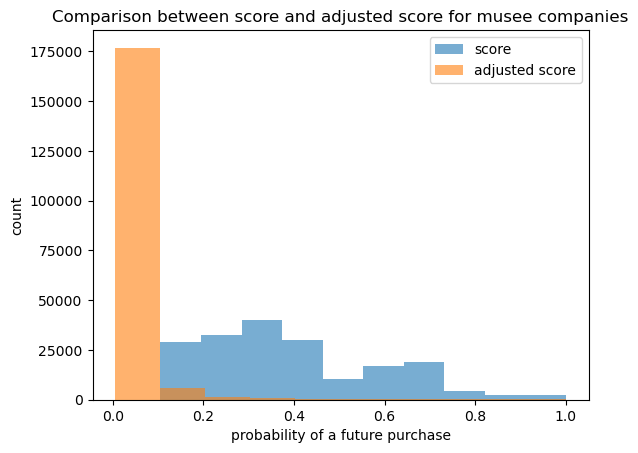

In [297]:
plot_hist_scores(X_test_segment, score = "score", score_adjusted = "score_adjusted", type_of_activity = type_of_activity)

In [40]:
# define path so save graphics

# define type of activity 
type_of_activity = "sport"
PATH = f"projet-bdc2324-team1/Output_expected_CA/{type_of_activity}/"
print(PATH)

projet-bdc2324-team1/Output_expected_CA/sport/


In [68]:
# export png 

# plot adjusted scores and save (to be tested)
plot_hist_scores(X_test_segment, score = "score", score_adjusted = "score_adjusted", type_of_activity = type_of_activity)

image_buffer = io.BytesIO()
plt.savefig(image_buffer, format='png')
image_buffer.seek(0)
file_name = "hist_score_adjusted_"
FILE_PATH_OUT_S3 = PATH + file_name + type_of_activity + ".png"
with fs.open(FILE_PATH_OUT_S3, 'wb') as s3_file:
    s3_file.write(image_buffer.read())
plt.close()

## Compute number of tickets and CA by segment with the recalibrated score

In [298]:
X_test_table_adjusted_scores = (100 * X_test_segment.groupby("quartile")[["score","score_adjusted", "has_purchased"]].mean()).round(2).reset_index()
X_test_table_adjusted_scores = X_test_table_adjusted_scores.rename(columns = {col : f"{col.replace('_', ' ')} (%)" for col in X_test_table_adjusted_scores.columns if col in ["score","score_adjusted", "has_purchased"]})
X_test_table_adjusted_scores

quartile  score (%)  score adjusted (%)  has purchased (%)
0        1      17.78                0.96               0.67
1        2      36.12                2.49               2.83
2        3      63.14                7.29               7.04
3        4      86.03               29.21              29.20

In [162]:
X_test_table_adjusted_scores.to_latex(index=False)

'\\begin{tabular}{lrrr}\n\\toprule\nquartile & score (%) & score adjusted (%) & has purchased (%) \\\\\n\\midrule\n1 & 13.250000 & 2.510000 & 1.570000 \\\\\n2 & 33.890000 & 8.000000 & 9.850000 \\\\\n3 & 63.060000 & 22.580000 & 21.470000 \\\\\n4 & 90.520000 & 66.200000 & 65.010000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [43]:
# comparison between score and adjusted score - export csv associated

file_name = "table_adjusted_score_"
FILE_PATH_OUT_S3 = PATH + file_name +  type_of_activity + ".csv"
with fs.open(FILE_PATH_OUT_S3, 'w') as file_out:
    X_test_table_adjusted_scores.to_csv(file_out, index = False)

In [106]:
def project_tickets_CA (df, nb_purchases, nb_tickets, total_amount, score_adjusted, duration_ref, duration_projection) :
    
    duration_ratio = duration_ref/duration_projection

    df_output = df

    df_output.loc[:,"nb_tickets_projected"] = df_output.loc[:,nb_tickets] / duration_ratio
    df_output.loc[:,"total_amount_projected"] = df_output.loc[:,total_amount] / duration_ratio
    
    df_output.loc[:,"nb_tickets_expected"] = df_output.loc[:,score_adjusted] * df_output.loc[:,"nb_tickets_projected"]
    df_output.loc[:,"total_amount_expected"] = df_output.loc[:,score_adjusted] * df_output.loc[:,"total_amount_projected"]

    df_output.loc[:,"pace_purchase"] = (duration_ref/df_output.loc[:,nb_purchases]).apply(lambda x : np.nan if x==np.inf else x)
    
    return df_output


In [107]:
X_test_segment = project_tickets_CA (X_test_segment, "nb_purchases", "nb_tickets", "total_amount", "score_adjusted", 
                                     duration_ref=17, duration_projection=12)
X_test_segment

/tmp/ipykernel_1080/3982240549.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_output.loc[:,"nb_tickets_projected"] = df_output.loc[:,nb_tickets] / duration_ratio
/tmp/ipykernel_1080/3982240549.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_output.loc[:,"total_amount_projected"] = df_output.loc[:,total_amount] / duration_ratio
/tmp/ipykernel_1080/3982240549.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

nb_tickets  nb_purchases  total_amount  nb_suppliers  \
0             4.0           1.0        100.00           1.0   
1             1.0           1.0         55.00           1.0   
2            17.0           1.0         80.00           1.0   
3             4.0           1.0        120.00           1.0   
4            34.0           2.0        416.00           1.0   
...           ...           ...           ...           ...   
96091         1.0           1.0         67.31           1.0   
96092         1.0           1.0         61.41           1.0   
96093         0.0           0.0          0.00           0.0   
96094         1.0           1.0         79.43           1.0   
96095         0.0           0.0          0.00           0.0   

       vente_internet_max  purchase_date_min  purchase_date_max  \
0                     0.0           5.177187           5.177187   
1                     0.0         426.265613         426.265613   
2                     0.0         436.033437         436.033437   
3                     0.0           5.196412           5.196412   
4                     0.0         478.693148         115.631470   
...                   ...                ...                ...   
96091                 1.0         278.442257         278.442257   
96092                 1.0         189.207373         189.207373   
96093                 0.0         550.000000         550.000000   
96094                 1.0         279.312905         279.312905   
96095                 0.0         550.000000         550.000000   

       time_between_purchase  nb_tickets_internet  fidelity  ...  \
0                   0.000000                  0.0         1  ...   
1                   0.000000                  0.0         2  ...   
2                   0.000000                  0.0         2  ...   
3                   0.000000                  0.0         1  ...   
4                 363.061678                  0.0         4  ...   
...                      ...                  ...       ...  ...   
96091               0.000000                  1.0         2  ...   
96092               0.000000                  1.0         1  ...   
96093              -1.000000                  0.0         1  ...   
96094               0.000000                  1.0         1  ...   
96095              -1.000000                  0.0         2  ...   

       has_purchased  has_purchased_estim     score  quartile  score_adjusted  \
0                0.0                  0.0  0.006066         1        0.001713   
1                1.0                  0.0  0.288847         2        0.102477   
2                0.0                  0.0  0.103264         1        0.031356   
3                0.0                  0.0  0.008928         1        0.002526   
4                1.0                  1.0  0.992809         4        0.974880   
...              ...                  ...       ...       ...             ...   
96091            1.0                  0.0  0.351762         2        0.132353   
96092            0.0                  1.0  0.567814         3        0.269714   
96093            0.0                  0.0  0.004652         1        0.001312   
96094            0.0                  0.0  0.293042         2        0.104362   
96095            0.0                  1.0  0.787852         4        0.510753   

       nb_tickets_projected  total_amount_projected  nb_tickets_expected  \
0                  2.823529               70.588235             0.004836   
1                  0.705882               38.823529             0.072337   
2                 12.000000               56.470588             0.376274   
3                  2.823529               84.705882             0.007132   
4                 24.000000              293.647059            23.397112   
...                     ...                     ...                  ...   
96091              0.705882               47.512941             0.093426   
96092              0.705882               43.34

In [108]:
X_test_segment.groupby("quartile")["pace_purchase"].mean()

quartile
1    15.578346
2    15.403993
3    12.415869
4     5.983541
Name: pace_purchase, dtype: float64

In [109]:
# generalization with a function

def summary_expected_CA(df, segment, nb_tickets_expected, total_amount_expected, total_amount, pace_purchase,
                       duration_ref=17, duration_projection=12) :
    
    # compute nb tickets estimated and total amount expected
    df_expected_CA = df.groupby(segment)[[nb_tickets_expected, total_amount_expected]].sum().reset_index()
    
    # number of customers by segment
    df_expected_CA.insert(1, "size", df.groupby(segment).size().values)
    
    # size in percent of all customers
    df_expected_CA.insert(2, "size_perct", 100 * df_expected_CA["size"]/df_expected_CA["size"].sum())
    
    # compute share of CA recovered
    duration_ratio=duration_ref/duration_projection
    
    df_expected_CA["revenue_recovered_perct"] = 100 * duration_ratio * df_expected_CA[total_amount_expected] / \
    df.groupby(segment)[total_amount].sum().values

    df_drop_null_pace = df.dropna(subset=[pace_purchase])
    df_expected_CA["pace_purchase"] = df_drop_null_pace.groupby(segment)[pace_purchase].mean().values
    
    return df_expected_CA

In [110]:
X_test_expected_CA = round(summary_expected_CA(df=X_test_segment, segment="quartile", 
                    nb_tickets_expected="nb_tickets_expected", total_amount_expected="total_amount_expected", 
                    total_amount="total_amount", pace_purchase="pace_purchase"),2)

X_test_expected_CA

quartile   size  size_perct  nb_tickets_expected  total_amount_expected  \
0        1  53565       55.74              1067.91               27626.39   
1        2  24607       25.61              4748.18              169941.72   
2        3   9716       10.11             11629.33              309933.79   
3        4   8208        8.54            215729.86            10042427.50   

   revenue_recovered_perct  pace_purchase  
0                     3.42          15.58  
1                    15.27          15.40  
2                    32.41          12.42  
3                    89.69           5.98

In [64]:
# Création du dictionnaire de mapping pour les noms de colonnes
mapping_dict = {col: col.replace("perct", "(%)").replace("_", " ") for col in X_test_expected_CA.columns}

X_test_expected_CA.rename(columns=mapping_dict).to_latex(index=False)

'\\begin{tabular}{lrrrrrr}\n\\toprule\nquartile & size & size (%) & nb tickets expected & total amount expected & revenue recovered (%) & pace purchase \\\\\n\\midrule\n1 & 53626 & 35.310000 & 398.260000 & 13949.330000 & 2.350000 & 16.480000 \\\\\n2 & 55974 & 36.860000 & 3113.770000 & 101639.450000 & 6.240000 & 16.470000 \\\\\n3 & 30435 & 20.040000 & 6214.350000 & 208267.220000 & 14.270000 & 15.710000 \\\\\n4 & 11839 & 7.800000 & 72929.460000 & 1835702.430000 & 75.380000 & 11.480000 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [122]:
# export summary table to the MinIO storage

file_name = "table_expected_CA_"
FILE_PATH_OUT_S3 = PATH + file_name +  type_of_activity + ".csv"
with fs.open(FILE_PATH_OUT_S3, 'w') as file_out:
    X_test_expected_CA.to_csv(file_out, index = False)

In [53]:
PATH = f"projet-bdc2324-team1/Output_expected_CA/{type_of_activity}/"
file_name = "table_expected_CA_"
FILE_PATH_OUT_S3 = PATH + file_name +  type_of_activity + ".csv"
FILE_PATH_OUT_S3

'projet-bdc2324-team1/Output_expected_CA/musique/table_expected_CA_musique.csv'

## Test : vizu tables saved

In [66]:
path = 'projet-bdc2324-team1/Output_expected_CA/sport/table_adjusted_scoresport.csv'

with fs.open( path, mode="rb") as file_in:
        df = pd.read_csv(file_in, sep=",")
df

quartile  score (%)  score adjusted (%)  has purchased (%)
0         1      13.25                2.51               1.57
1         2      33.89                8.00               9.85
2         3      63.06               22.58              21.47
3         4      90.52               66.20              65.01

## Just to try, same computation with score instead of score adjusted

seems overestimated : if only 14% of customers come back, how can we recover 22% of the revenue from the segment that is least likely to buy ?? ...

In [80]:
X_test_segment_bis = project_tickets_CA (X_test_segment, "nb_tickets", "total_amount", "score", duration_ref=1.5, duration_projection=1)

X_test_expected_CA_bis = round(summary_expected_CA(df=X_test_segment_bis, segment="quartile", nb_tickets_expected="nb_tickets_expected", 
                    total_amount_expected="total_amount_expected", total_amount="total_amount"),2)

X_test_expected_CA_bis

quartile   size  size_perct  nb_tickets_expected  total_amount_expected  \
0        1  37410       38.93               419.76                9245.08   
1        2  29517       30.72             11549.06              296522.02   
2        3  20137       20.96             29997.85              954751.91   
3        4   9032        9.40            244655.82            10736011.95   

   perct_revenue_recovered  
0                    21.71  
1                    39.24  
2                    63.34  
3                    97.72

In [81]:
print("overall share of revenue recovered : ", round(100 * duration_ratio * X_test_expected_CA_bis["total_amount_expected"].sum() / \
X_test_segment_bis["total_amount"].sum(),2), "%")

overall share of revenue recovered :  90.26 %


## Last pieces of analysis

In [161]:
# global revenue recovered
global_revenue_recovered = round(100 * duration_ratio * X_test_expected_CA["total_amount_expected"].sum() / \
X_test_segment["total_amount"].sum(),2)
print(f"overall share of revenue recovered : {global_revenue_recovered}%")

overall share of revenue recovered : 77.64%


In [163]:
100 * X_test_expected_CA["total_amount_expected"]/X_test_expected_CA["total_amount_expected"].sum()

0     0.018093
1     0.721519
2     3.336101
3    95.924287
Name: total_amount_expected, dtype: float64

In [166]:
# le segment 4 représente 83% du CA actuel et 96% du CA lié aux anciens clients pour l'année prochaine
100 * X_test_segment.groupby("quartile")["total_amount"].sum()/X_test_segment["total_amount"].sum()

quartile
1     0.320407
2     5.685020
3    11.339715
4    82.654858
Name: total_amount, dtype: float64

In [177]:
X_test_segment["total_amount"].describe() # total amount négatif ???


count     96096.000000
mean        207.475735
std        4720.046248
min      -48831.800000
25%           0.000000
50%           0.000000
75%          60.000000
max      624890.000000
Name: total_amount, dtype: float64

In [184]:
np.cumsum(X_test_segment["total_amount"].sort_values()).reset_index()["total_amount"]

0       -4.883180e+04
1       -6.483180e+04
2       -7.683860e+04
3       -8.683860e+04
4       -9.683860e+04
             ...     
96091    1.802247e+07
96092    1.839238e+07
96093    1.877219e+07
96094    1.931270e+07
96095    1.993759e+07
Name: total_amount, Length: 96096, dtype: float64